In [318]:
import pandas as pd
import numpy as np

In [319]:
df = pd.read_csv('./output/data/features.csv')

In [320]:
df.columns

Index(['file_path', 'sampling_rate', 'label', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean',
       'chroma_2_mean', 'chroma_3_mean', 'zcr_mean',
       'spectral_contrast_1_mean', 'spectral_contrast_2_mean',
       'spectral_contrast_3_mean', 'spectral_contrast_4_mean',
       'spectral_contrast_5_mean', 'spectral_contrast_6_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'lpc_1_mean', 'lpc_2_mean', 'lpc_3_mean',
       'lpc_4_mean', 'lpc_5_mean', 'lpc_6_mean', 'lpc_7_mean', 'lpc_8_mean',
       'lpc_9_mean', 'lpc_10_mean', 'lpc_11_mean', 'lpc_12_mean'],
      dtype='object')

In [321]:
# Drop the 'file_path' column
data = df.drop(columns=['file_path', 'sampling_rate'])

# Convert 'label' column values from 'fake' and 'real' to 0 and 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'fake' else 1)

# Display the updated dataframe
data.head()

,label,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,lpc_3_mean,lpc_4_mean,lpc_5_mean,lpc_6_mean,lpc_7_mean,lpc_8_mean,lpc_9_mean,lpc_10_mean,lpc_11_mean,lpc_12_mean
0,0,-392.408060,122.706493,4.529471,-1.131724,10.133050,-7.359573,-12.236763,-11.748826,-14.925097,...,0.206947,0.242434,0.083058,-0.000745,0.017267,0.048853,0.049655,0.011606,-0.013775,0.056669
1,1,-288.633987,150.553761,-51.823300,9.575870,16.140331,-25.634484,-9.063233,-13.583262,-33.734496,...,0.942317,0.165730,-0.168018,-0.083517,0.020074,0.079114,0.045597,-0.013818,-0.022306,0.027391
2,1,-321.349296,128.728553,-45.678164,16.015681,2.248679,-36.931314,-16.453398,-21.782121,-28.765838,...,0.791051,0.180148,-0.195515,-0.059862,0.091892,0.056669,-0.024036,-0.031334,0.023492,0.031977
3,1,-300.014392,139.610539,-58.775005,-17.863993,-27.983239,-31.165856,-15.891464,-29.907360,-18.892911,...,0.625773,0.182251,-0.158980,-0.015436,0.072798,0.026417,0.033397,0.026217,-0.038438,0.072341
4,0,-313.237382,128.302576,-47.012209,19.925841,13.332181,-29.089705,-13.109960,-17.376589,-20.631608,...,0.469962,0.320646,-0.054736,-0.086741,0.068926,0.095494,0.023775,-0.018482,0.001961,0.045553


In [322]:
data.shape

(3000, 39)

In [323]:
# 1. Load and preprocess data
features = data[['mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean',
       'chroma_2_mean', 'chroma_3_mean', 'zcr_mean',
       'spectral_contrast_1_mean', 'spectral_contrast_2_mean',
       'spectral_contrast_3_mean', 'spectral_contrast_4_mean',
       'spectral_contrast_5_mean', 'spectral_contrast_6_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'lpc_1_mean', 'lpc_2_mean', 'lpc_3_mean',
       'lpc_4_mean', 'lpc_5_mean', 'lpc_6_mean', 'lpc_7_mean', 'lpc_8_mean',
       'lpc_9_mean', 'lpc_10_mean', 'lpc_11_mean', 'lpc_12_mean']] # Select features
labels = data['label']

In [324]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import pad_sequences
from keras.regularizers import l2

In [325]:
def create_sequences(features, sequence_length, overlap):
    """
    Creates sequences from feature data.

    Args:
        features: A NumPy array of shape (num_samples, num_features).
        sequence_length: The desired length of each sequence.
        overlap: The number of overlapping features between consecutive sequences.

    Returns:
        A tuple containing:
            - A NumPy array of shape (num_sequences, sequence_length, num_features).
            - A list of indices indicating the starting sample of each sequence.
    """
    sequences = []
    indices = []  # Store the starting index of each sequence
    for i in range(0, len(features) - sequence_length + 1, sequence_length - overlap):
        sequences.append(features[i: i + sequence_length])
        indices.append(i)  # Store the starting index
    return np.array(sequences), indices

In [326]:
def prepare_data(X, window_size = 10):
    
    data = []
    
    for i in range(len(X)):
        row = X.iloc[i].values
        row_data = []
        for j in range(len(row) - window_size):
            window = row[j : j + window_size]
            row_data.append(window)
        data.append(row_data)
        
    return np.array(data)

In [327]:
features.iloc[:, :] = MinMaxScaler().fit_transform(features)
new_X = prepare_data(features, window_size = 5)

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_73753/3845254570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.iloc[:, :] = MinMaxScaler().fit_transform(features)


In [328]:
X_train, X_test, y_train, y_test = train_test_split(new_X, labels.values, test_size=0.2, shuffle = True, stratify = labels.values, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state=42)

In [329]:
model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2])
model.add(Input(shape=input_shape))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss = BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                  │ (None, 33, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_69 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

In [330]:
callback = [
    ModelCheckpoint(filepath='model.keras'),
]

In [331]:
history = model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data = (X_val, y_val), callbacks = callback)

Epoch 1/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4995 - loss: 0.6940 - val_accuracy: 0.4917 - val_loss: 0.6976
Epoch 2/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5082 - loss: 0.6945 - val_accuracy: 0.4917 - val_loss: 0.6930
Epoch 3/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4927 - loss: 0.6940 - val_accuracy: 0.5083 - val_loss: 0.6928
Epoch 4/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5036 - loss: 0.6925 - val_accuracy: 0.5979 - val_loss: 0.6922
Epoch 5/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5076 - loss: 0.6928 - val_accuracy: 0.5625 - val_loss: 0.6890
Epoch 6/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5480 - loss: 0.6883 - val_accuracy: 0.6208 - val_loss: 0.6661
Epoch 7/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5505 - loss: 0.6874 - val_accuracy: 0.5875 - val_loss: 0.6755
Epoch 8/60
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5592 - loss: 0.6796 - val_accuracy: 0.6000 - v

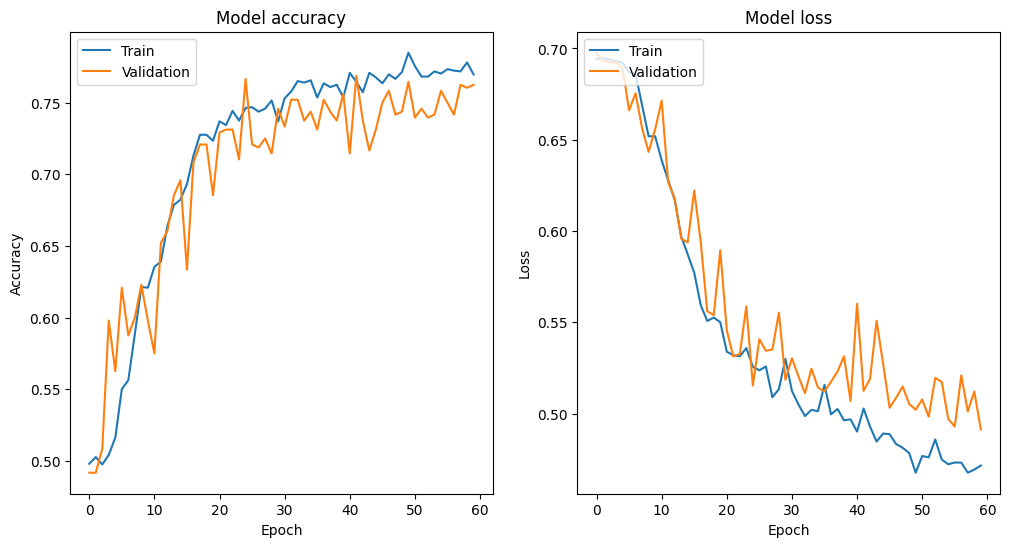

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7731 - loss: 0.4602
Test Loss: 0.45381155610084534
Test Accuracy: 0.778333306312561


In [332]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# 5. Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)